# Speech Commands Recognition (Keyword Spotting)

In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from IPython.display import display, Audio, Image

from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score, log_loss, cohen_kappa_score

from scipy.io import wavfile

from models_utils import available_models, select_model
import plot_utils 

plt.rcParams['font.size'] = '12'
# %matplotlib inline

2023-01-12 18:31:02.504840: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-12 18:31:03.037203: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-12 18:31:03.037256: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-12 18:31:04.127706: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

To extract MFCC features from audio signals we use the Python library [python_speech_features](https://github.com/jameslyons/python_speech_features).

In [2]:
# uncomment to install python_speech_features
# ! pip install python_speech_features

from python_speech_features import logfbank, mfcc, delta

To perform Discrete Wavelet Transform on audio signals we use the Python library [PyWavelets](https://github.com/PyWavelets/pywt).

In [3]:
# uncomment to install pywt
# ! pip install pywt

from pywt import dwt

## 1 - Data loading and preprocessing
In this project we use the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands), which contains short (one-second long) audio clips of English commands, stored as audio files in the WAV format. More in detail, the version 0.02 of the dataset contains 105.829 utterances of 35 short words, by thousands of different people. It was released on April 11th 2018 under [Creative Commons BY 4.0 license](https://creativecommons.org/licenses/by/4.0/) and collected using crowdsourcing, through [AIY](https://aiyprojects.withgoogle.com/) by Google. Some of these words are "yes", "no", "up", "down", "left", "right", "on", "off", "stop" and "go".

### 1.1 - Download data and create data folder
We import both a smaller version of the Speech Commands dataset and the full version. The mini dataset can be used for testing and demo reasons, however the entire work will be focused only on the complete dataset (or a subset of it). 

In [4]:
choose_dataset = 2  # 1 for mini, 2 for full

DATASET_PATH_mini = 'data/mini_speech_commands'
DATASET_PATH_full = 'data/full_speech_commands'

data_dir_mini = pathlib.Path(DATASET_PATH_mini)
if not data_dir_mini.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
  print('\n')
  
data_dir_full = pathlib.Path(DATASET_PATH_full)
if not data_dir_full.exists():
  tf.keras.utils.get_file(
      'full_speech_commands.zip',
      origin="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz",
      extract=True,
      cache_dir='.', cache_subdir='data/full_speech_commands')
  print('\n')
  
if choose_dataset==1:
  data_dir = data_dir_mini
  data_path = DATASET_PATH_mini
  print('Working with the mini dataset!')
elif choose_dataset==2:
  data_dir = data_dir_full
  data_path = DATASET_PATH_full
  print('Working with the full dataset!')
else:
  print("Error, 'choose_dataset' must be 1 or 2")

Working with the full dataset!


### 1.2 - Dataset organization
The audio files are organized into folders based on the word they contain. For more details see \[[Warden18](https://arxiv.org/abs/1804.03209)\].

**Mini dataset** <br>
The dataset's audio clips are stored in 8 folders corresponding to each speech command: `down`, `go`, `left`, `no`, `right`, `stop`, `up`, `yes`, and `stop`. 

**Full dataset** <br>
The dataset's audio clips are stored in 35 folders corresponding to each speech command: <br>
`backward`, `bed`, `bird`, `cat`, `dog`, `down`, `eight`, `five`, `follow`, `forward`, `four`, `go`, `happy`, `house`, `learn`, `left`, `marvin`, `nine`, `no`, `off`, `on`, `one`, `right`, `seven`, `sheila`, `six`, `stop`, `three`, `tree`, `two`, `up`, `visual`, `wow`, `yes`, `zero`




In [5]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

if choose_dataset==1:
  mask = commands != 'README.md'

elif choose_dataset==2:
  mask = (
      np.array(commands != 'README.md')                 &
      np.array(commands != 'LICENSE')                   &
      np.array(commands != '.DS_Store')                 &
      np.array(commands != 'training_list.txt')         &  
      np.array(commands != 'validation_list.txt')       &  
      np.array(commands != 'testing_list.txt')          &  
      np.array(commands != 'full_speech_commands.zip')  &
      np.array(commands != '_background_noise_')        
  )
  
commands = commands[mask]
print('Commands:', commands)

print('\nNumber of commands: %i' %len(commands))

Commands: ['on' 'three' 'off' 'learn' 'down' 'marvin' 'house' 'bird' 'dog' 'one'
 'eight' 'two' 'five' 'seven' 'left' 'yes' 'up' 'six' 'nine' 'sheila'
 'zero' 'four' 'go' 'no' 'wow' 'right' 'bed' 'tree' 'stop' 'cat' 'happy'
 'backward' 'visual' 'forward' 'follow']

Number of commands: 35


### 1.3 - Processing of the original audio files 
The original audio files were captured in a variety of formats and then converted to .WAV file at a 16000 sample rate. The audio was then trimmed to a one second length to align most utterances, using the [extract_loudest_section](https://github.com/petewarden/extract_loudest_section) tool. The audio files were then screened for silence or incorrect words, and arranged into folders by label.

### 1.4 - Training, testing and validation sets
The text files `validation_list.txt` and `testing_list.txt` available in the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) contain the paths to all the files in each set, with each path on a new line. Any files that aren't in either of these lists can be considered to be part of the training set. The validation and test set sizes thus obtained are approximatly 10% of the size of the complete set. For more information on how the partition is made, see the README.md file of the dataset. 

The following code performs these operations:
- Load the reference validation and testing files as separated Pandas dataframe objects. 
- Store the path of all audio files in a dictionary. 
- Create the reference file for training data, by storing in a Pandas dataframe object the paths of all files that aren't in the validation or testing list. If it has been already created, we simply import it as we did for the reference validation and testing files. 

To each file we associate the corresponding label (i.e. the name of the folder it is in), so that we get a proper labeling for each file to be used with our loss function. Of course, we still need to load the actual data.

In [6]:
training_list_path = data_path + "/training_list.txt"

reference_df_val = pd.read_csv(data_path+"/validation_list.txt", sep="/", header=None, names=['label', 'file'])
reference_df_test = pd.read_csv(data_path+"/testing_list.txt", sep="/", header=None, names=['label', 'file'])

# all audio files
all_files = {}
for command in commands:
    all_files[command] = os.listdir(data_path+'/'+command)
    
num_files = 0
for x_ in all_files.values():
    num_files += len(x_)
        
print('There are %i audio files in the dataset' %num_files)

# reference file for training set
# if already exists import it
if pathlib.Path(training_list_path).exists(): 
    reference_df_train =  pd.read_csv(data_path+"/training_list.txt", sep="/", header=None, names=['label', 'file'])
    
# else create it and store the dataframe as a .txt file; creating the pd object can take some time
else:
    reference_df_train = pd.DataFrame(columns=['label', 'file'])
    for i, command in enumerate(commands):
        print("Processing command '%s', %i commands missing..." %(command, len(commands)-i-1))
        for file in all_files[command]:
            if file in reference_df_val['file'].values:
                continue
            if file in reference_df_test['file'].values:
                continue
            
            reference_df_train.loc[len(reference_df_train)] = [command, file]
              
    print('Done!')
    print('\n')
    
    # store reference_df_train in .txt file
    reference_df_train.to_csv(data_path+'/training_list.txt', header=None, index=None, sep='/', mode='a')

# print the result
# print('----------------------------')
# print('TRAINING FILES:')
# print(reference_df_train)
# print('----------------------------')
# print('VALIDATION FILES:')
# print(reference_df_val)
# print('----------------------------')
# print('TESTING FILES:')
# print(reference_df_test)

There are 105829 audio files in the dataset


Encode target labels with value between 0 and n_commands-1.

In [7]:
label_to_class = {commands[i]:i for i in range(len(commands))}
# label_to_class

In [8]:
class_to_label = {i:commands[i] for i in range(len(commands))}
# class_to_label

In [9]:
reference_df_train['class'] = reference_df_train['label'].map(label_to_class)
reference_df_val['class']   = reference_df_val['label'].map(label_to_class)
reference_df_test['class']  = reference_df_test['label'].map(label_to_class)

# print the result
print('TRAINING FILES:')
print(reference_df_train)
print('----------------------------')
print('VALIDATION FILES:')
print(reference_df_val)
print('----------------------------')
print('TESTING FILES:')
print(reference_df_test)

TRAINING FILES:
          label                   file  class
0      backward  0165e0e8_nohash_0.wav     31
1      backward  017c4098_nohash_0.wav     31
2      backward  017c4098_nohash_1.wav     31
3      backward  017c4098_nohash_2.wav     31
4      backward  017c4098_nohash_3.wav     31
...         ...                    ...    ...
84838      zero  ffd2ba2f_nohash_1.wav     20
84839      zero  ffd2ba2f_nohash_2.wav     20
84840      zero  ffd2ba2f_nohash_3.wav     20
84841      zero  ffd2ba2f_nohash_4.wav     20
84842      zero  fffcabd1_nohash_0.wav     20

[84843 rows x 3 columns]
----------------------------
VALIDATION FILES:
      label                   file  class
0     right  a69b9b3e_nohash_0.wav     25
1     right  439c84f4_nohash_1.wav     25
2     right  409c962a_nohash_1.wav     25
3     right  dbaf8fc6_nohash_2.wav     25
4     right  a6d586b7_nohash_1.wav     25
...     ...                    ...    ...
9976   four  d107dc42_nohash_0.wav     21
9977   four  ad63d93c_n

#### 1.4.1 - Smoke dataset
We enable the possibility to perform some tests without loading the entire dataset by setting `smoke_test=True`. With this option the train, validation and test set are reduced to a fraction `smoke_test_frac` of elements. This can be useful to test if everything is working as intended before the full training, or if the current hardware is not powerful enough. 

In [10]:
smoke_test = True
smoke_test_frac = 0.3
smoke_test_threshold = 1000 # minimum length of reduced datasets

if smoke_test:
    len_min = smoke_test_frac * min(len(reference_df_train), len(reference_df_val), len(reference_df_test))
    if len_min < smoke_test_threshold:
        raise Exception(f'One of the reduced datasets would have a number of samples < {smoke_test_threshold}! Select a larger value for "smoke_test_frac".')
    else: 
        reference_df_train = reference_df_train.sample(frac=smoke_test_frac, replace=False)
        reference_df_val   = reference_df_val.sample(frac=smoke_test_frac, replace=False)
        reference_df_test  = reference_df_test.sample(frac=smoke_test_frac, replace=False)

In [11]:
print('TRAINING SET')
print('\tnumber of audio files: %i' %len(reference_df_train))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_train)/num_files*100))

print('VALIDATION SET')
print('\tnumber of audio files: %i' %len(reference_df_val))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_val)/num_files*100))

print('TEST SET')
print('\tnumber of audio files: %i' %len(reference_df_test))
print('\tpercentage of audio files: %.2f%%' %(len(reference_df_test)/num_files*100))

TRAINING SET
	number of audio files: 25453
	percentage of audio files: 24.05%
VALIDATION SET
	number of audio files: 2994
	percentage of audio files: 2.83%
TEST SET
	number of audio files: 3302
	percentage of audio files: 3.12%


#### 1.4.2 - Dataset distribution
Let's now plot the percentage of elements of each class in each set. 

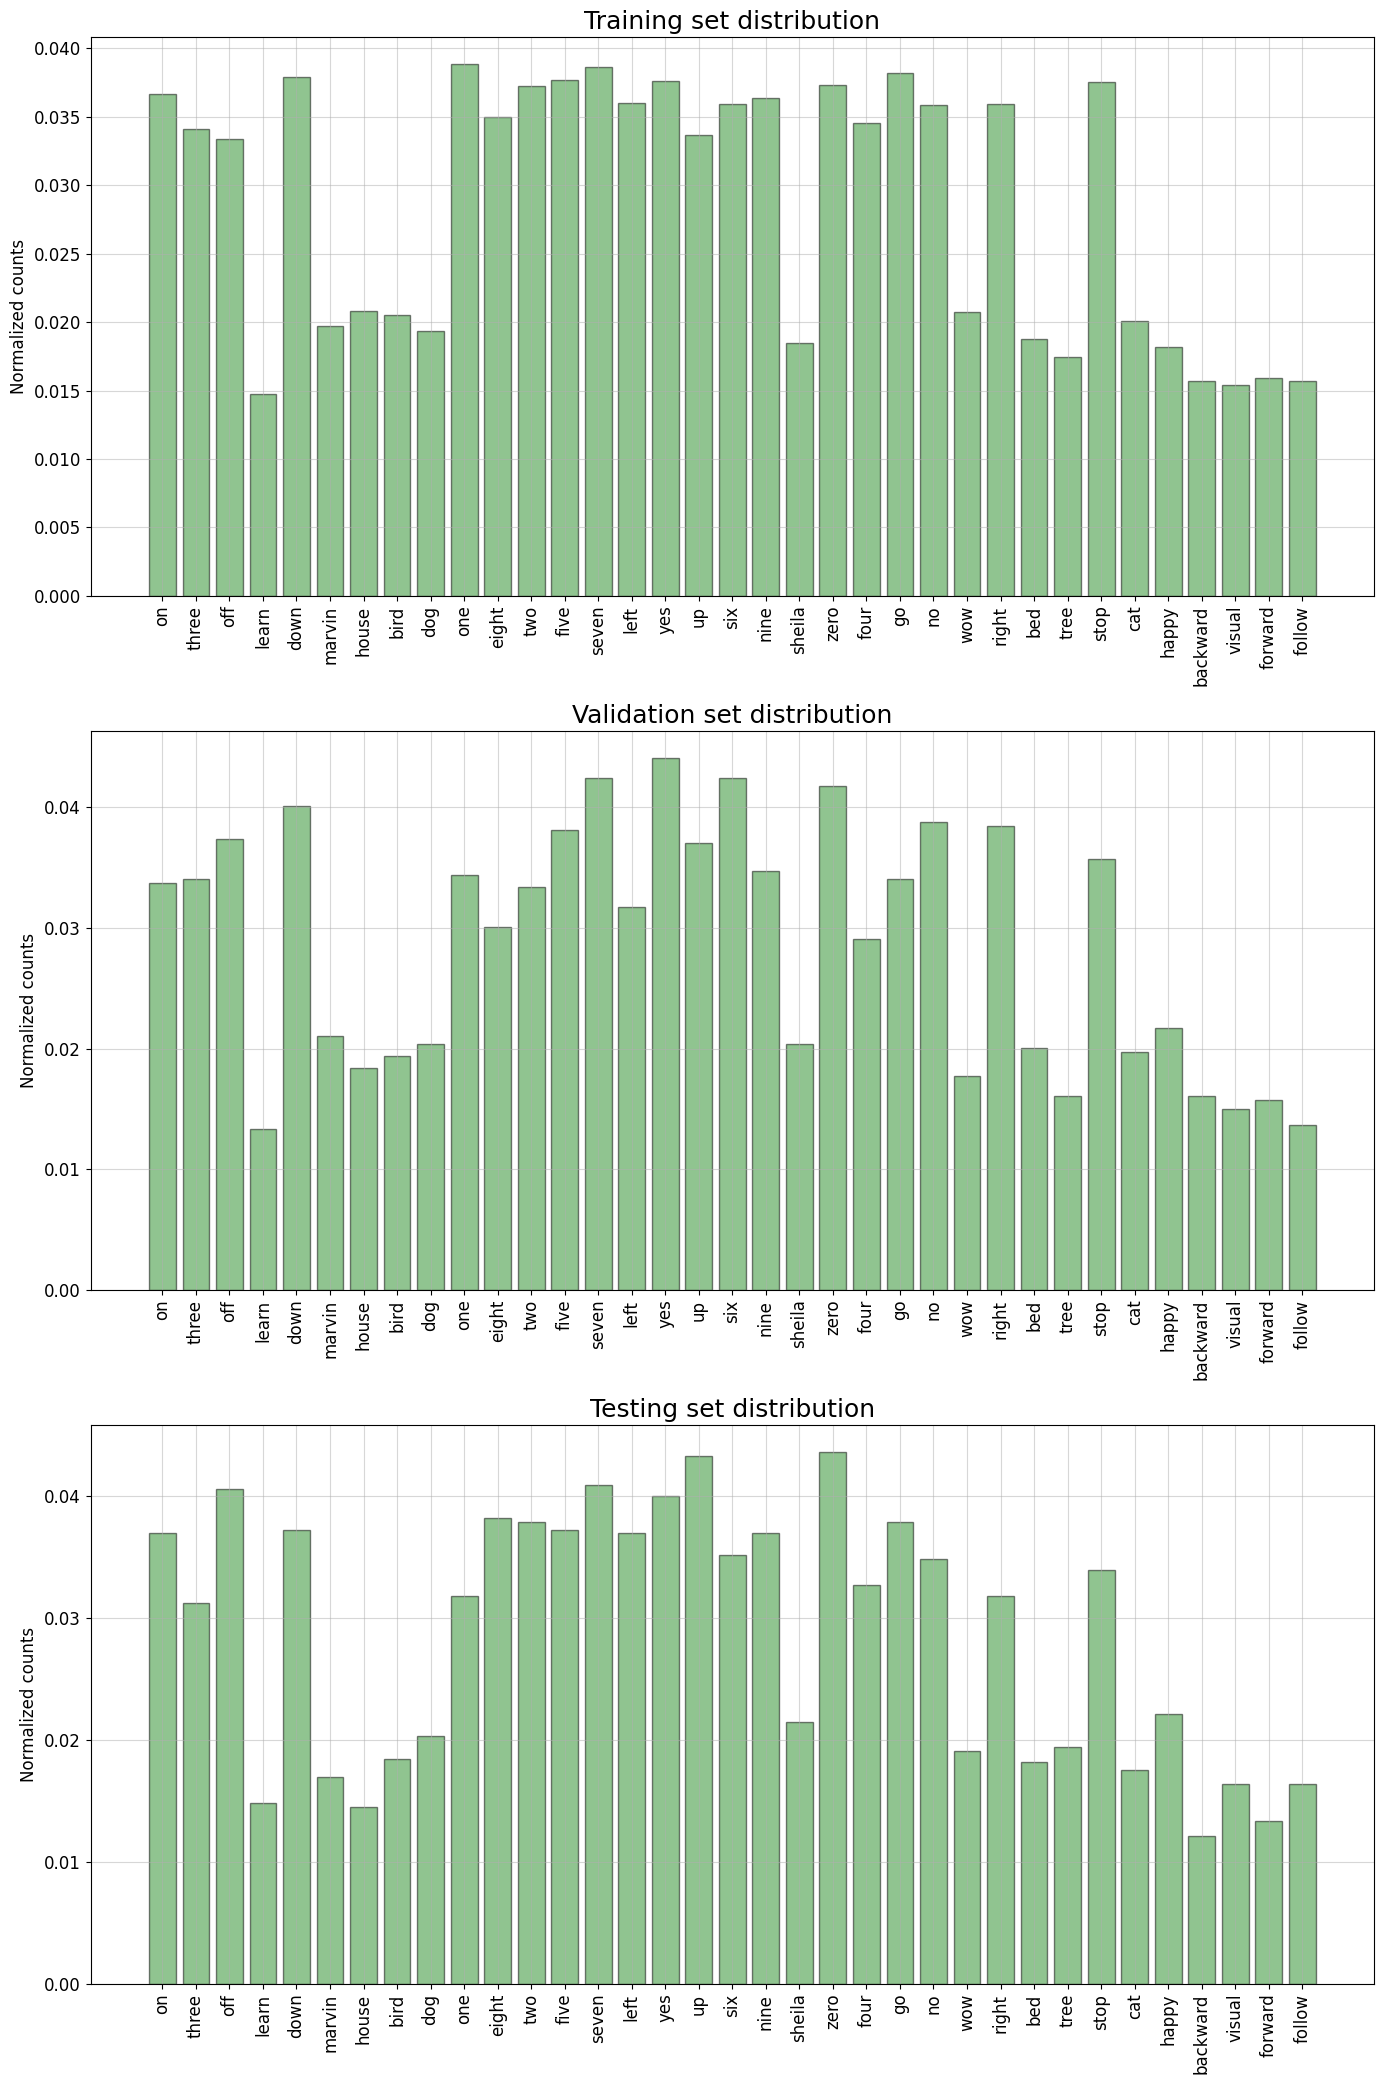

In [12]:
fig, ax = plt.subplots(3, 1, figsize=(14, 21))

plot_utils.hist_class_distribution(reference_df_train, ax[0], commands)
plot_utils.hist_class_distribution(reference_df_val, ax[1], commands)
plot_utils.hist_class_distribution(reference_df_test, ax[2], commands)

for i in range(3):
    ax[i].set_ylabel('Normalized counts')
    ax[i].grid(alpha=0.5)
    ax[i].tick_params(axis='x', labelrotation=90)
    
ax[0].set_title('Training set distribution', fontsize=18)
ax[1].set_title('Validation set distribution', fontsize=18)
ax[2].set_title('Testing set distribution', fontsize=18)

plt.tight_layout()
plt.show()

### 1.5 - Load data
Now we define a function to load the actual audio signals from the files. As data is stored as .wav files, we can load it using the  `wavfile.read` function from the scipy library ([doc here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.io.wavfile.read.html)). 

The function takes in input the path of the file to be loaded, that can be obtained from the filename *file_name* (.wav) and the corresponding label *file_label* as:
```python
    file_path = data_path + '/' + file_label + '/' + file_name
```
Then, `wavfile.read(file_path)` returns a tuple of two items: the first is the sampling rate in samples per second, the second is a numpy array with all the data read from the file. As this dataset only contains single channel audio, after getting the data we use the `np.squeeze` function to drop the extra axis.

We show an example for the label _yes_ and one for the label _no_.

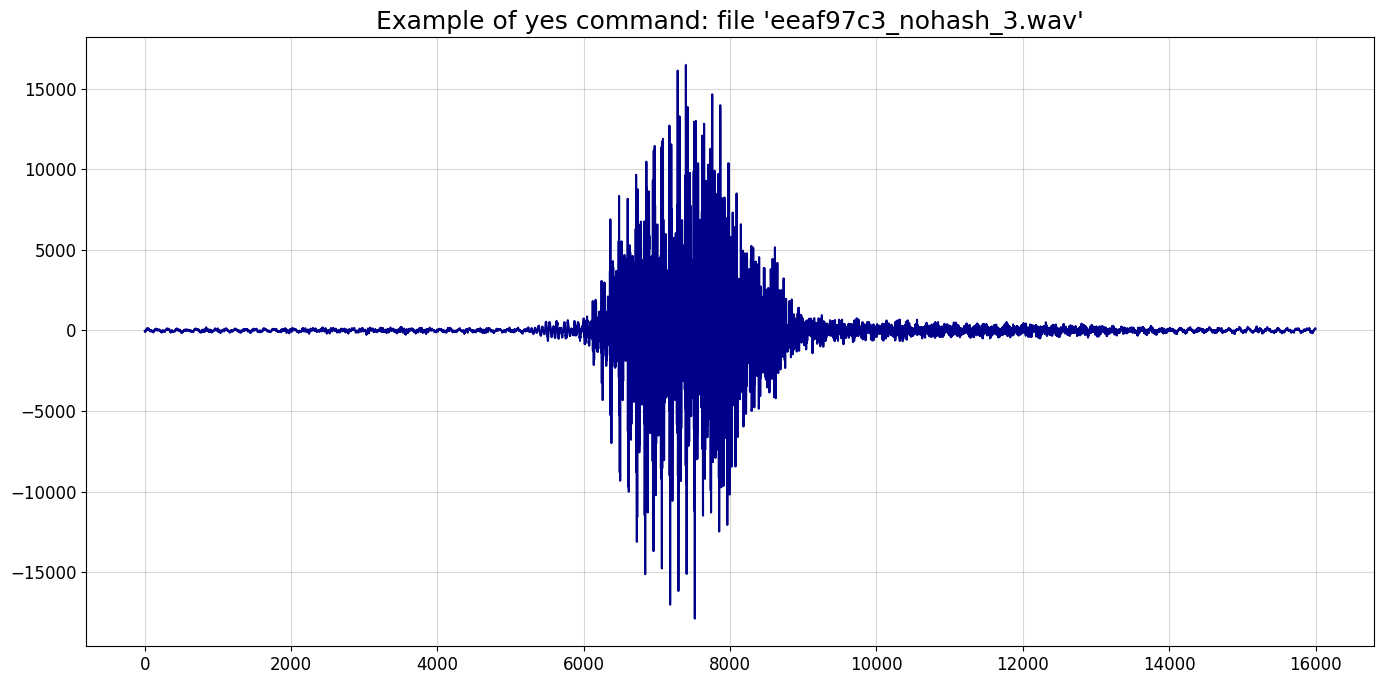

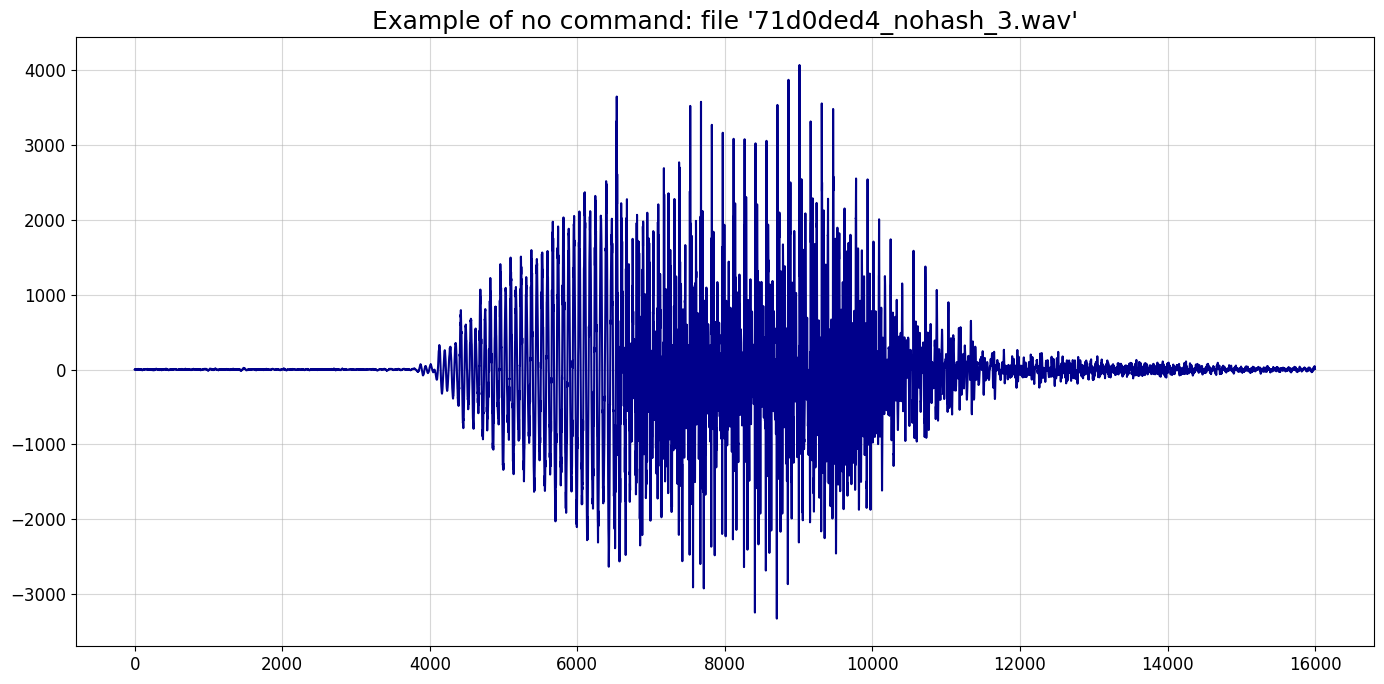

In [13]:
def load_data(file_name, file_label, data_path_=data_path):
    if isinstance(file_name, bytes):
        file_name = file_name.decode()
    if isinstance(file_label, bytes):
        file_label = file_label.decode()
    if isinstance(data_path_, bytes):
        data_path_ = data_path_.decode()

    if not isinstance(file_label, str):
        file_label = class_to_label[file_label]

    file_path = data_path_ + '/' + file_label + '/' + file_name
    _, data = wavfile.read(file_path)

    return data.squeeze()

# Examples
# Plot a 'yes' command from training set
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]
yes_data = load_data(plot_obj.file, plot_obj.label)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(yes_data, color='darkblue')
ax.grid(alpha=0.5)
ax.set_title("Example of yes command: file '{}'".format(plot_obj.file), fontsize=18)

plt.tight_layout()
plt.show()

# Plot a 'no' command from training set
plot_obj = reference_df_train[reference_df_train.label=='no'].iloc[10]
no_data = load_data(plot_obj.file, plot_obj.label)

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(no_data, color='darkblue')
ax.grid(alpha=0.5)
ax.set_title("Example of no command: file '{}'".format(plot_obj.file), fontsize=18)

plt.tight_layout()
plt.show()

### 1.6 - Preprocessing: trimming and padding
Let's print the shape of some training data to see if they are all equal or there are some variations. 

In [14]:
for i in range(50):
    data = load_data(reference_df_train.iloc[i].file, reference_df_train.iloc[i].label)
    print('File: {} - Shape: {}'.format(reference_df_train.iloc[i].file, data.shape))

File: 27c24504_nohash_1.wav - Shape: (16000,)
File: 22296dbe_nohash_2.wav - Shape: (16000,)
File: 4c6944d6_nohash_1.wav - Shape: (16000,)
File: ddedba85_nohash_1.wav - Shape: (16000,)
File: c98bbbd3_nohash_0.wav - Shape: (16000,)
File: 589bce2c_nohash_0.wav - Shape: (16000,)
File: 39833acb_nohash_1.wav - Shape: (16000,)
File: 15c563d7_nohash_0.wav - Shape: (16000,)
File: f2e9b610_nohash_3.wav - Shape: (16000,)
File: 4def68db_nohash_0.wav - Shape: (16000,)
File: 069ab0d5_nohash_0.wav - Shape: (16000,)
File: e6327279_nohash_3.wav - Shape: (16000,)
File: afd53389_nohash_1.wav - Shape: (16000,)
File: e53139ad_nohash_2.wav - Shape: (16000,)
File: a1cf7fd8_nohash_0.wav - Shape: (16000,)
File: a77fbcfd_nohash_4.wav - Shape: (16000,)
File: ede2f4ee_nohash_0.wav - Shape: (15604,)
File: 888a0c49_nohash_0.wav - Shape: (16000,)
File: 5188de0d_nohash_1.wav - Shape: (16000,)
File: 4e99c1b7_nohash_1.wav - Shape: (16000,)
File: 0b7ee1a0_nohash_2.wav - Shape: (16000,)
File: 7cf14c54_nohash_2.wav - Shap

Notice for example that the file 'no/0a396ff2_nohash_0.wav' has shape (9557,), meaning that not all audio files have the same shape. The audio clips are 1 second or less at 16kHz, so we need to pad the short ones to exactly 1 second (and eventually trim the longer ones), so that the samples can be processed by the neural network, that requires a fixed input shape. Most of the samples have 16000 samples (1 second at 16kHz sampling frequency), so let's use this value as our fixed input shape.

In the following function, audio files longer than `output_sequence_length=160000` will be truncated to `output_sequence_length`, while audio signals shorter than this are padded to get the same length. The padding is otained using the `np.pad` function with `mode='mean'` ([doc here](https://numpy.org/doc/stable/reference/generated/numpy.pad.html)). More in detail, we pad half on the left (`int(np.ceil(tot_pads / 2))`) and half on the right (`int(np.floor(tot_pads / 2))`).

When truncating the signal, we decided **not** to randomly select a portion of the signal, as we noticed that in this case we typically don't lose any information by simply cropping it to [0, output_sequence_length-1].


In [15]:
def padding_trimming(data, output_sequence_length=16000):
    data_shape = data.shape[0]
    
    # trimming
    if data_shape>output_sequence_length:
        data=data[:output_sequence_length]
    
    # padding
    elif data_shape<output_sequence_length:
        tot_pad = output_sequence_length-data_shape
        pad_before = int(np.ceil(tot_pad/2))
        pad_after  = int(np.floor(tot_pad/2))
        data = np.pad(data, pad_width=(pad_before, pad_after), mode='mean')
        
    return data

# let's test it on a audio file with correct length
if not smoke_test:
    plot_obj = reference_df_train[(reference_df_train.file=='f1d36c53_nohash_0.wav') & (reference_df_train.label=='off')].iloc[0]
    data = load_data(plot_obj.file, plot_obj.label)
    print('File: %s/{} - Shape: {}'.format(plot_obj.file, data.shape) %(plot_obj.label))
    
    data = padding_trimming(data)
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(data, color='darkblue')
    ax.grid(alpha=0.5)
    ax.set_title("File '{}', no padding needed".format(plot_obj.file), fontsize=18)
    
    plt.tight_layout()
    plt.show()
    
    # let's test it on 0a396ff2_nohash_0.wav, as we know it needs padding
    plot_obj = reference_df_train[(reference_df_train.file=='0a396ff2_nohash_0.wav') & (reference_df_train.label=='no')].iloc[0]
    data = load_data(plot_obj.file, plot_obj.label)
    print('File: %s/{} - Shape: {}'.format(plot_obj.file, data.shape)  %(plot_obj.label))
    
    data_new = padding_trimming(data)
    print('\nAfter padding:')
    print('File: %s/{} - Shape: {}'.format(plot_obj.file, data_new.shape)  %(plot_obj.label))
    
    fig, ax = plt.subplots(figsize=(14, 7))
    ax.plot(np.arange((16000-data.shape[0])//2, (16000-data.shape[0])//2+data.shape[0]), data, color='darkblue', label='Original signal', zorder=2)
    ax.plot(data_new, color='red', label='Padding', zorder=1)
    ax.grid(alpha=0.5)
    ax.set_title("File '%s/{}' padding needed".format(plot_obj.file) %(plot_obj.label), fontsize=18)
    ax.legend(edgecolor='black', facecolor='linen', fontsize=12, loc ='upper left')
    
    plt.tight_layout()
    plt.show()

![](example1.png)
![](example2.png)

### 1.7 - Background Noise 
To help train machine learning models to cope with noisy environments, it can be helpful to mix in realistic background audio. The `_background_noise_` folder contains a set of longer audio clips that are either recordings or mathematical simulations of noise. They were all either collected personally by Pete Warden in July 2017, or generated in the case of the pink and white noise. For more details, see the `_background_noise_/README.md`.

We define a function to mix one of these background audio signals into an input audio clip. With `select_noise` it is possible to select which of the available background audio clips to use. In particular, the following match is applied:

$1 \longrightarrow $ doing_the_dishes.wav <br>
$2 \longrightarrow $ dude_miaowing.wav <br>
$3 \longrightarrow $ exercise_bike.wav <br>
$4 \longrightarrow $ pink_noise.wav <br>
$5 \longrightarrow $ running_tap.wav <br>
$6 \longrightarrow $ white_noise.wav 

If `select_noise=None` (default value), then the background noise is randomly chosen between the available ones. Moreover, as these clips  still have a 16kHz sample rate but are longer than 1 second, we randomly select a portion of them to match the size of the input.


/tmp/ipykernel_5529/2041177136.py:13: WavFileWarning: Chunk (non-data) not understood, skipping it.
  _, data = wavfile.read(file_path)


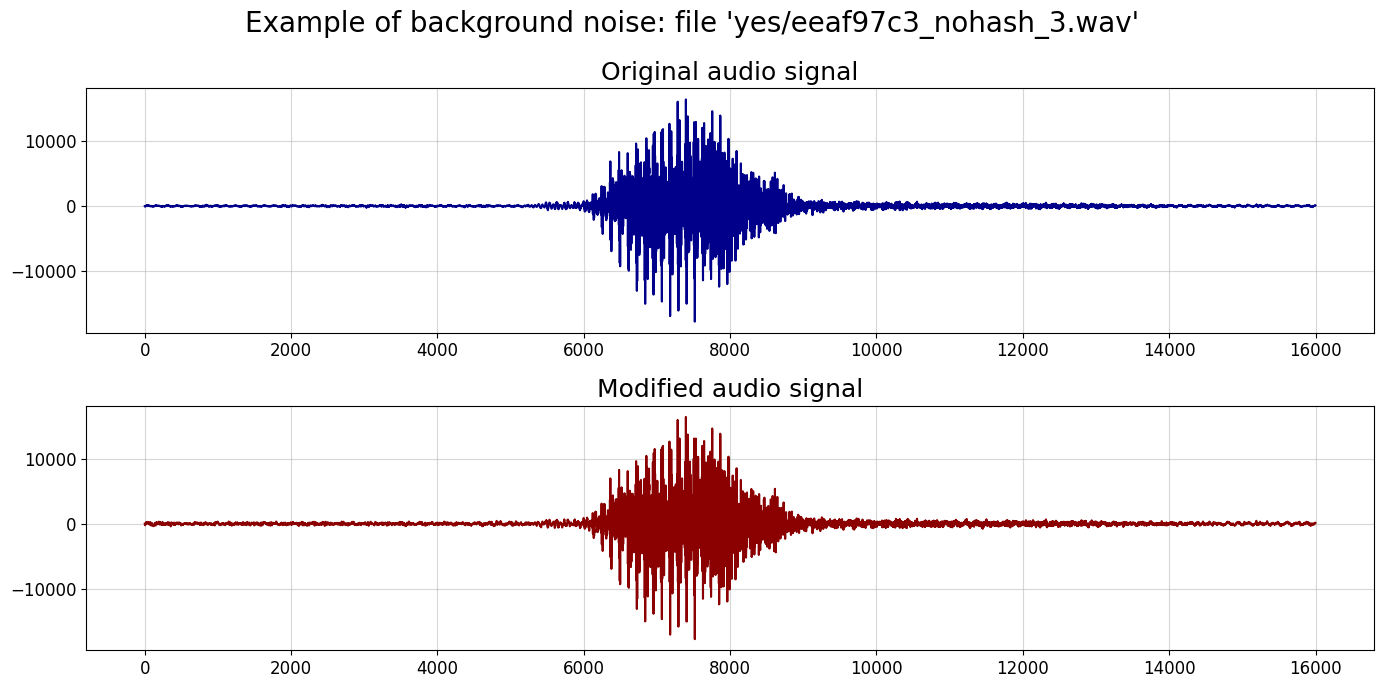

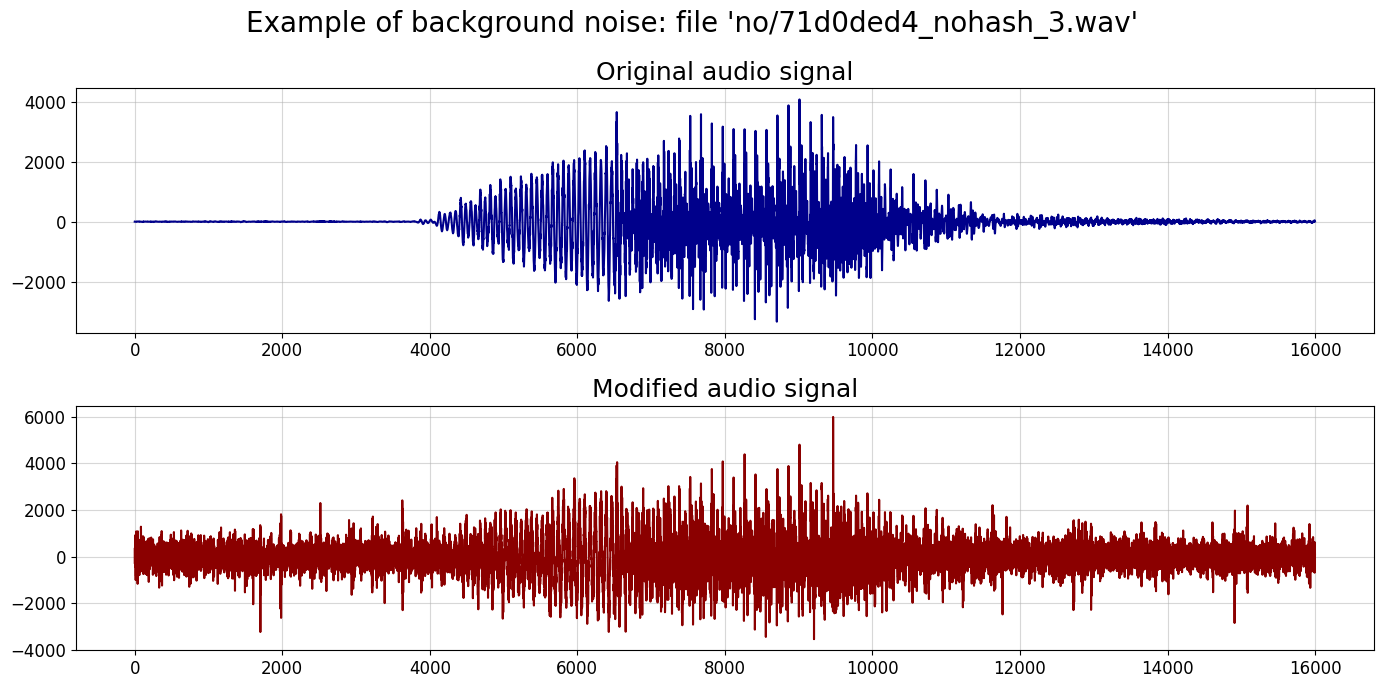

In [16]:
noise_path = '_background_noise_'

# load all noises 
noise_1 = load_data('doing_the_dishes.wav', noise_path)
noise_2 = load_data('dude_miaowing.wav', noise_path)
noise_3 = load_data('exercise_bike.wav', noise_path)
noise_4 = load_data('pink_noise.wav', noise_path)
noise_5 = load_data('running_tap.wav', noise_path)
noise_6 = load_data('white_noise.wav', noise_path)

noise_dict = {
    '1': noise_1, 
    '2': noise_2, 
    '3': noise_3, 
    '4': noise_4, 
    '5': noise_5, 
    '6': noise_6
}

def background_noise(data, select_noise=None, noise_reduction=0.8):
    '''
    data: input audio signal, already loaded and preprocessed, it must be a numpy array 
    select_noise: decide what kind of noise to add to the input signal, by default a random choice 
    noise_reduction: set it to a value between 0 and 1 to reduce the amount of noise, by default 0.8
    '''
    
    target_size = data.shape[0]
    
    # None case
    if select_noise is None:
        select_noise = np.random.choice(np.arange(1, 7))
        
    # other cases, plus random selection  
    noise_data = noise_dict[str(select_noise)]
    N = noise_data.shape[0]
    
    # random cropping
    from_ = np.random.randint(0, int(N-target_size))
    to_ = from_ + target_size
    noise_data = noise_data[from_:to_]
    
    # add noise to input audio
    data_with_noise = data + (1-noise_reduction)*noise_data
    
    return data_with_noise
        
# Let's test it on the same examples we used before
np.random.seed(22)

# 'yes' command from training set, with 'doing_the_dishes.wav' background noise
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]
yes_data = load_data(plot_obj.file, plot_obj.label)

yes_data_wn = background_noise(yes_data, select_noise=1)

fig, ax = plt.subplots(2, 1, figsize=(14, 7))
ax[0].plot(yes_data, color='darkblue')
ax[1].plot(yes_data_wn, color='darkred')

for i in range(2):
    ax[i].grid(alpha=0.5)

ax[0].set_title('Original audio signal', fontsize=18)
ax[1].set_title('Modified audio signal', fontsize=18)
fig.suptitle("Example of background noise: file 'yes/{}'".format(plot_obj.file), fontsize=20)

plt.tight_layout()
plt.show()

# 'no' command from training set, with random background noise
plot_obj = reference_df_train[reference_df_train.label=='no'].iloc[10]
no_data = load_data(plot_obj.file, plot_obj.label)

no_data_wn = background_noise(no_data)

fig, ax = plt.subplots(2, 1, figsize=(14, 7))
ax[0].plot(no_data, color='darkblue')
ax[1].plot(no_data_wn, color='darkred')

for i in range(2):
    ax[i].grid(alpha=0.5)

ax[0].set_title('Original audio signal', fontsize=18)
ax[1].set_title('Modified audio signal', fontsize=18)
fig.suptitle("Example of background noise: file 'no/{}'".format(plot_obj.file), fontsize=20)

plt.tight_layout()
plt.show()

Let's play these audio signals.  

In [17]:
# Audio(yes_data, rate=16000)

# Audio(yes_data_wn, rate=16000)

# Audio(no_data, rate=16000)

# Audio(no_data_wn, rate=16000)

### 1.8 - Extract features

#### 1.8.1 - Spectrogram

The waveforms in the dataset are represented in the time domain. Next, we'll transform the waveforms from the time-domain signals into the frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. We will feed the spectrogram images into our neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor on which standard convolutions can be runned.

Let's create a utility function for converting waveforms to spectrograms:

- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, we'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [18]:
def get_spectrogram(
                    signal,                               # audio signal from which to compute features (N*1 array)
                    samplerate = 16000,                   # samplerate of the signal we are working with
                    winlen     = 25,                      # length of the analysis window (milliseconds)
                    winstep    = 10,                      # step between successive windows (milliseconds)
                    nfft       = 512,                     # FFT size
                    winfunc    = tf.signal.hamming_window # analysis window to apply to each frame
                    ):

    # Convert the waveform to a spectrogram via a STFT
    spectrogram = tf.signal.stft(
                                signal.astype(float),
                                int(samplerate*winlen/1000),
                                int(samplerate*winstep/1000),
                                nfft,
                                winfunc
                                )

    # Obtain the magnitude of the STFT
    spectrogram = tf.abs(spectrogram)

    # Convert to NumPy array
    spectrogram = np.array(spectrogram)

    # Convert the frequencies to log scale and transpose, so that the time is represented on the x-axis (columns)
    # Add an epsilon to avoid taking a log of zero
    spectrogram = np.log(spectrogram.T + np.finfo(float).eps)

    return spectrogram

Let's sample a random audio signal from `reference_df_train` and extract the corresponding spectrogram.

2023-01-12 18:31:10.164951: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-12 18:31:10.165076: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-12 18:31:10.165104: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Daniele-PC): /proc/driver/nvidia/version does not exist
2023-01-12 18:31:10.165659: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Feature vector shape: (257, 98)


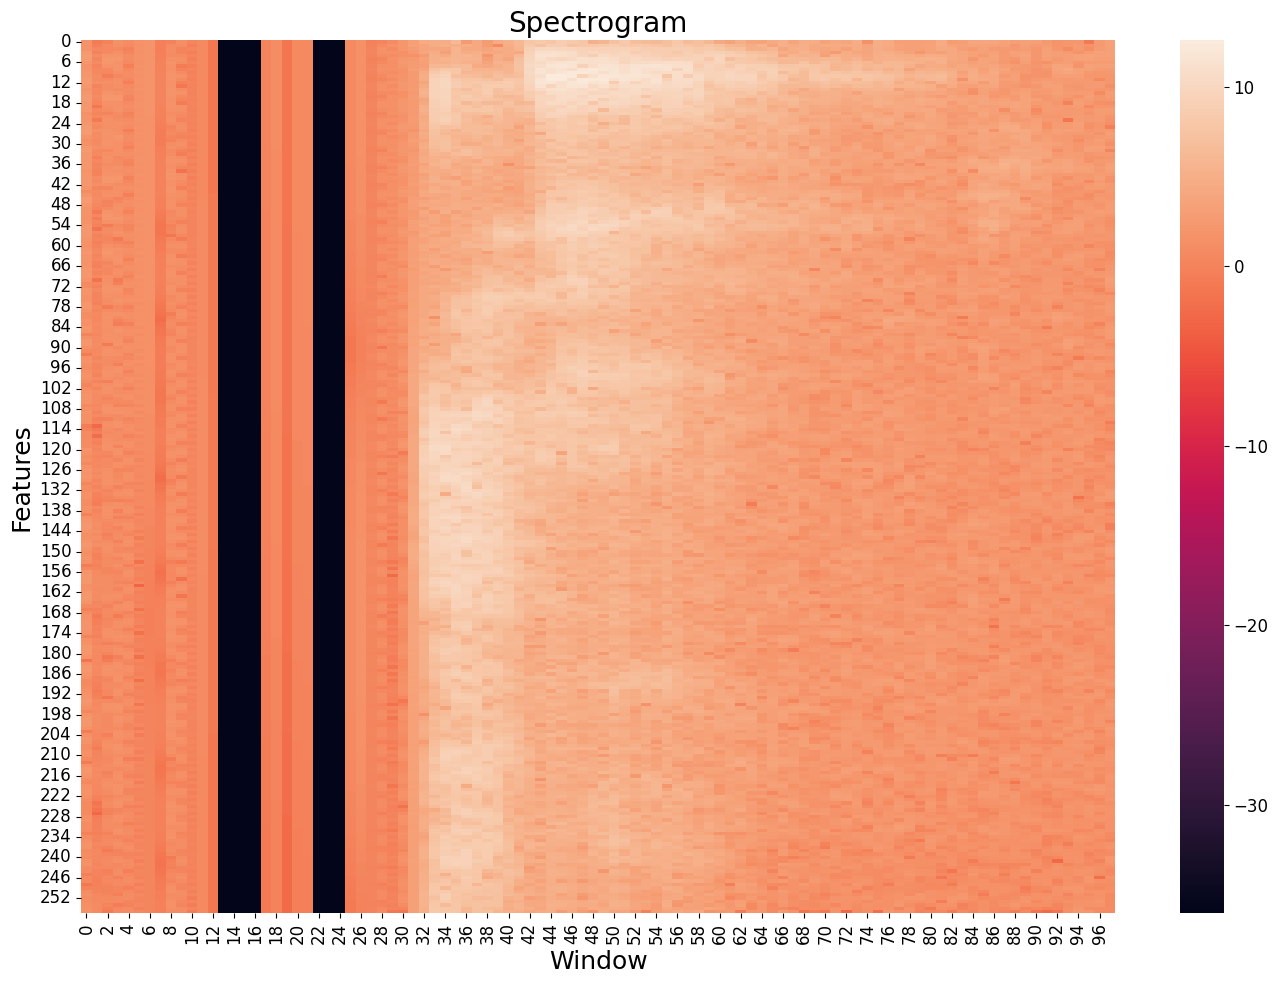

In [19]:
plot_obj = reference_df_train.sample().squeeze()
signal = load_data(plot_obj.file, plot_obj.label)

spectrogram = get_spectrogram(signal)
print("Feature vector shape:", spectrogram.shape)
plot_utils.plot_features(spectrogram, title='Spectrogram')

#### 1.8.2 - Log Mel-filterbank energy features

In [20]:
def get_logfbank(
                signal,             # audio signal from which to compute features (N*1 array)
                samplerate = 16000, # samplerate of the signal we are working with
                winlen     = 25,    # length of the analysis window (milliseconds)
                winstep    = 10,    # step between successive windows (milliseconds)
                nfilt      = 40,    # number of filters in the filterbank
                nfft       = 512,   # FFT size
                lowfreq    = 300,   # lowest band edge of mel filters (Hz)
                highfreq   = None,  # highest band edge of mel filters (Hz)
                ):

    if highfreq is None:
        highfreq = samplerate / 2

    # Extract log Mel-filterbank energy features
    logfbank_feat = logfbank(
                            signal,
                            samplerate,
                            winlen/1000,
                            winstep/1000,
                            nfilt,
                            nfft,
                            lowfreq,
                            highfreq,
                            )
    logfbank_feat = logfbank_feat.T

    return logfbank_feat

Let's sample a random audio signal from `reference_df_train` and extract log Mel-filterbank energy features from it.

Feature vector shape: (40, 99)


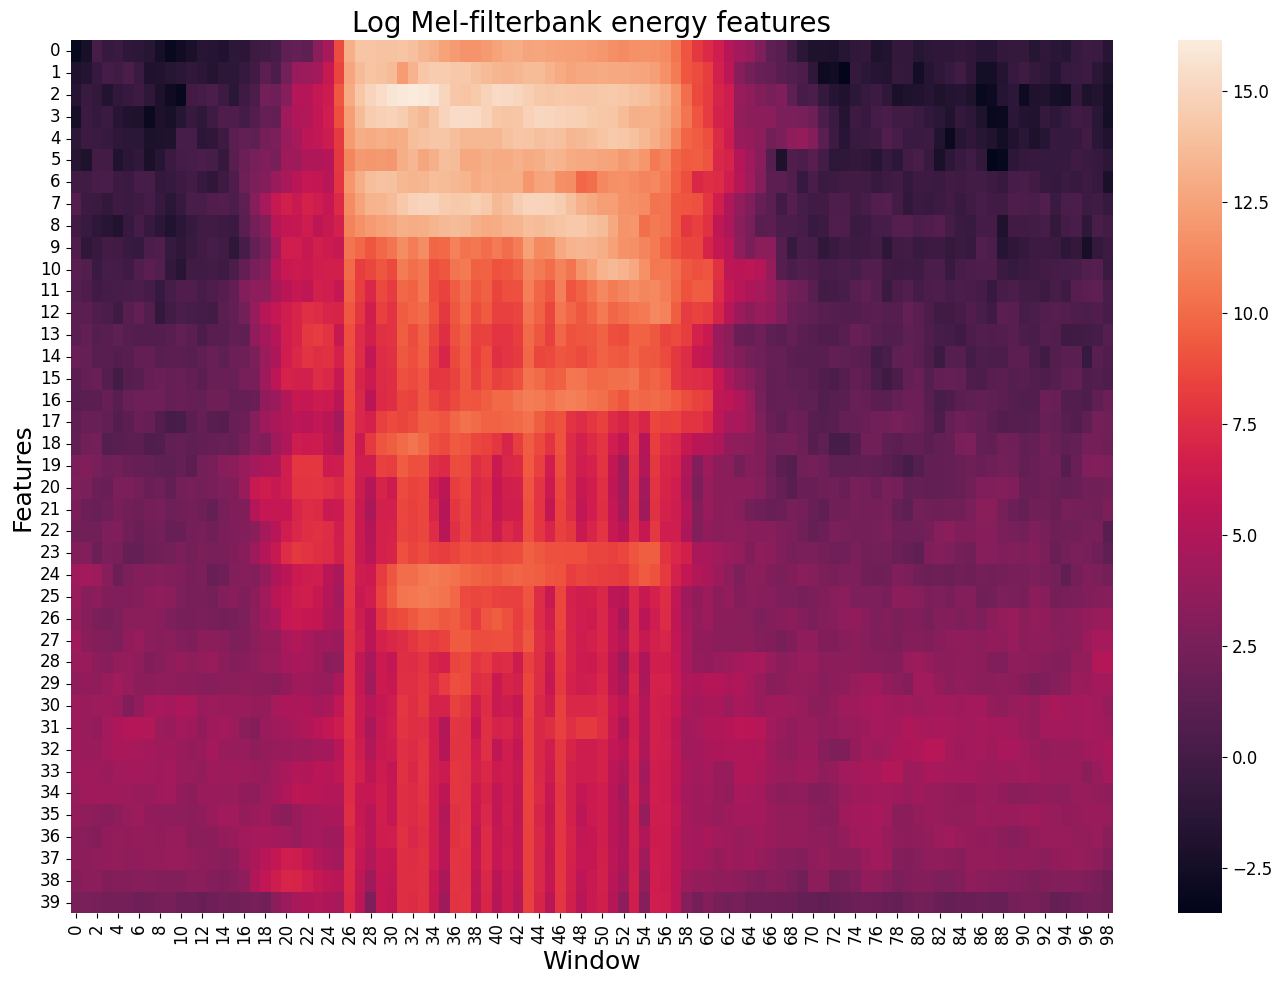

In [21]:
plot_obj = reference_df_train.sample().squeeze()
signal = load_data(plot_obj.file, plot_obj.label)

logfbank_features = get_logfbank(signal)
print("Feature vector shape:", logfbank_features.shape)
plot_utils.plot_features(logfbank_features, title='Log Mel-filterbank energy features')

#### 1.8.3 - MFCC features
Reference: [A Step-by-Step Guide to Speech Recognition and Audio Signal Processing in Python | Towards Data Science](https://towardsdatascience.com/a-step-by-step-guide-to-speech-recognition-and-audio-signal-processing-in-python-136e37236c24) 

MFCC is a technique designed to extract features from an audio signal. It uses the Mel scale to divide the audio signal’s frequency bands and then extracts coefficients from each individual frequency band, thus, creating a separation between frequencies. MFCC uses the Discrete Cosine Transform (DCT) to perform this operation. The Mel scale is established on the human perception of sound, i.e., how the human brain process audio signals and differentiates between the varied frequencies.

Unless written otherwise, we compute the features framing the signal into 25ms time windows with a 10ms frame shift and using 40 Mel filterbanks.

In [22]:
def get_mfcc(
            signal,                    # audio signal from which to compute features (N*1 array)
            samplerate   = 16000,      # samplerate of the signal we are working with
            winlen       = 25,         # length of the analysis window (milliseconds)
            winstep      = 10,         # step between successive windows (milliseconds)
            numcep       = 13,         # number of cepstrum to return
            nfilt        = 40,         # number of filters in the filterbank
            nfft         = 512,        # FFT size
            lowfreq      = 300,        # lowest band edge of mel filters (Hz)
            highfreq     = None,       # highest band edge of mel filters (Hz)
            appendEnergy = True,       # if this is true, the zeroth cepstral coefficient is replaced with the log of the total frame energy
            winfunc      = np.hamming, # analysis window to apply to each frame
            delta_order  = 2,          # maximum order of the Delta features
            delta_window = 1           # window size for the Delta features
            ):

    if highfreq is None:
        highfreq = samplerate / 2

    features = []

    # Extract MFCC features
    mfcc_feat = mfcc(
                    signal,
                    samplerate,
                    winlen/1000,
                    winstep/1000,
                    numcep,
                    nfilt,
                    nfft,
                    lowfreq,
                    highfreq,
                    appendEnergy=appendEnergy,
                    winfunc=winfunc                
                    )
    mfcc_feat = mfcc_feat.T
    features.append(mfcc_feat)

    # Extract Delta features
    for i in range(delta_order):

        features.append(delta(features[-1], delta_window))

    # Full feature vector
    full_feat = np.vstack(features)

    return full_feat

Let's sample a random audio signal from `reference_df_train` and extract MFCC features from it.

Feature vector shape: (39, 99)


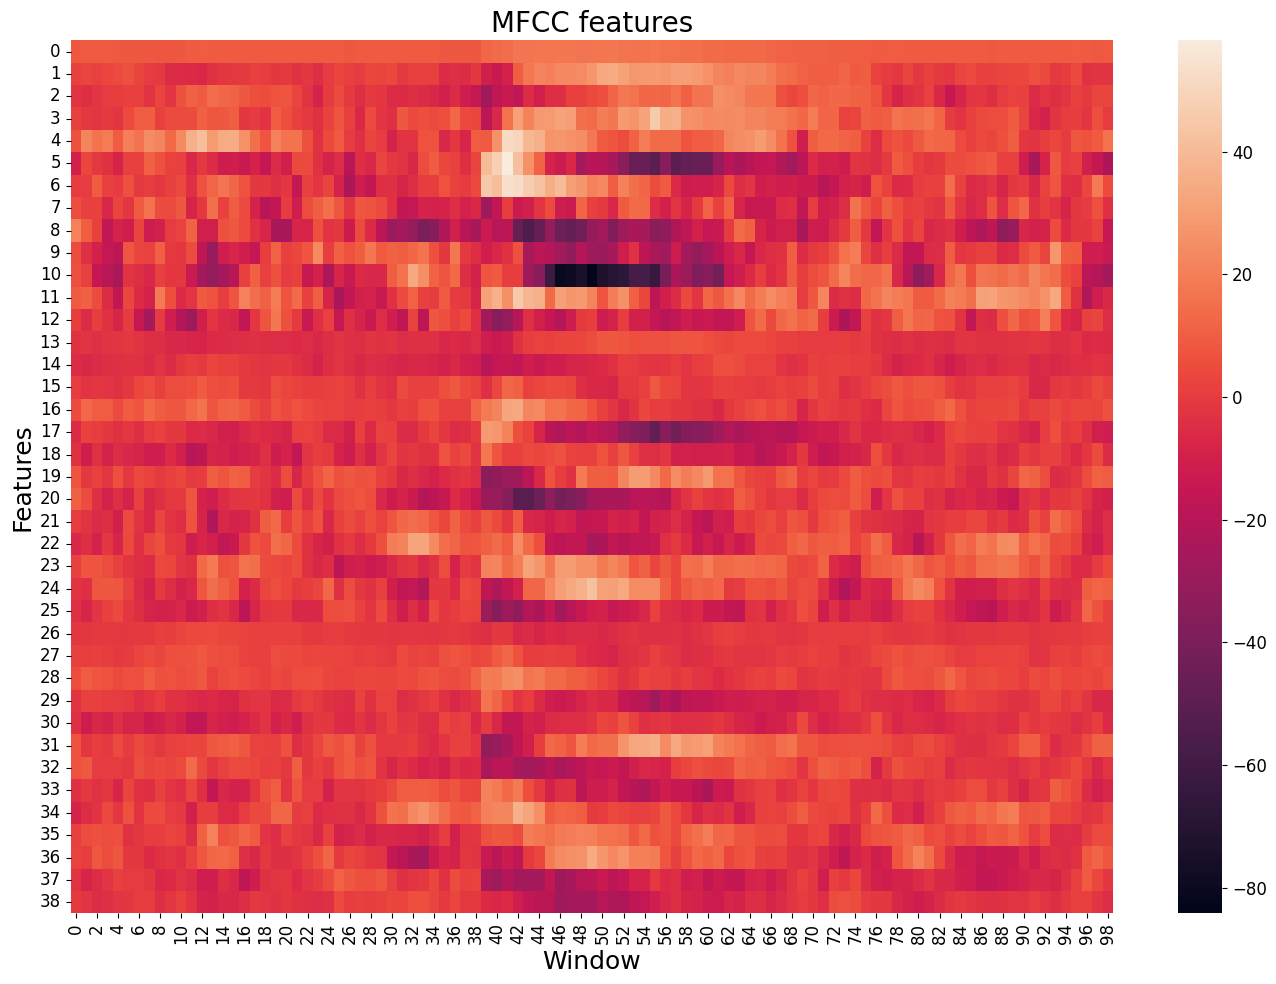

In [23]:
plot_obj = reference_df_train.sample().squeeze()
signal = load_data(plot_obj.file, plot_obj.label)

mfcc_features = get_mfcc(signal)
print("Feature vector shape:", mfcc_features.shape)
plot_utils.plot_features(mfcc_features, title='MFCC features')

## 2 - Data Loading using the Dataset API
As the dataset is quite large (>5GiB), there is the risk that it will not entirely fit in the memory, plus the preprocessing pipeline would be computationally intensive. For these reasons, we want to implement a proper and optimized data-loading pipeline, as reading the data can be the main bottleneck of the entire training process. This can be done by exploit the [Tensorflow Dataset API](https://www.tensorflow.org/guide/datasets).

The main goal of this phase is to create a `tf.data.Dataset` object to efficiently load and preprocess your data. First, we put together the loading and preprocessing methods in a single function `load_and_preprocess_data`.

In [24]:
def load_and_preprocess_data(file_name, file_label, data_path_=data_path, apply_background_noise=False, features=1):
    '''
    features:
    - 1 for MFCC features (default)
    - 2 for log Mel-filterbank energy features
    - 3 for spectrogram
    - 4 for Discrete Wavelet Transform + MFCC features
    '''
    
    # load data
    data = load_data(file_name, file_label, data_path_=data_path)
    
    # padding/trimming
    data = padding_trimming(data)
    
    # add background noise
    if apply_background_noise:
        data = background_noise(data)

    # extract features
    if features == 1:
        data_features = get_mfcc(data)
    
    elif features == 2:
        data_features = get_logfbank(data)

    elif features == 3:
        data_features = get_spectrogram(data)

    elif features == 4:
        data, _ = dwt(data=data, wavelet='db1', mode='sym')
        data_features = get_mfcc(data)
      
    else:
        raise Exception("'features' must be 1 or 2")
    
    # TensorFlow takes as input 32-bit floating point data
    return data_features.astype(np.float32)

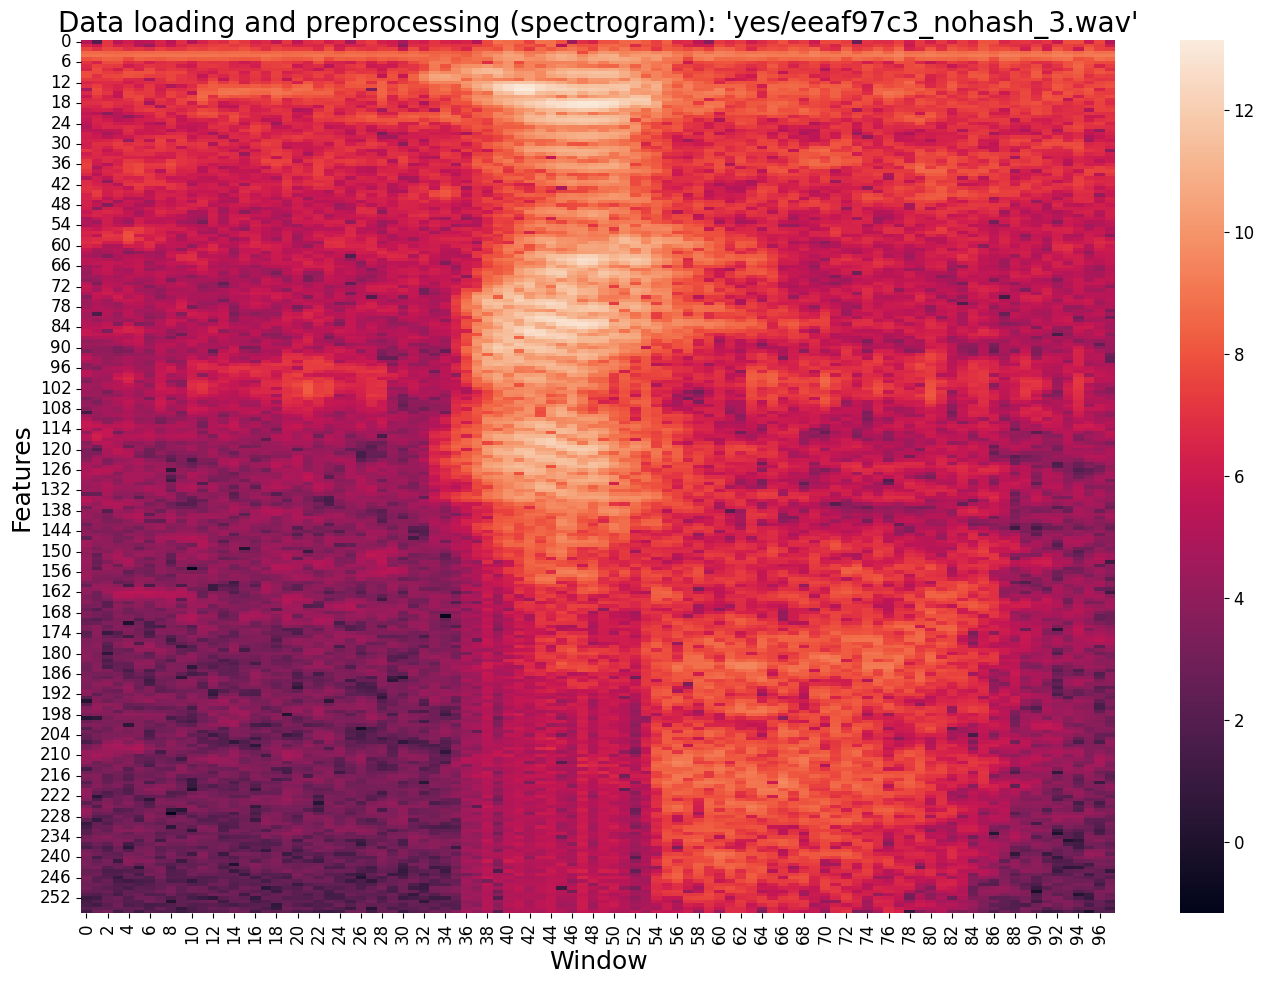

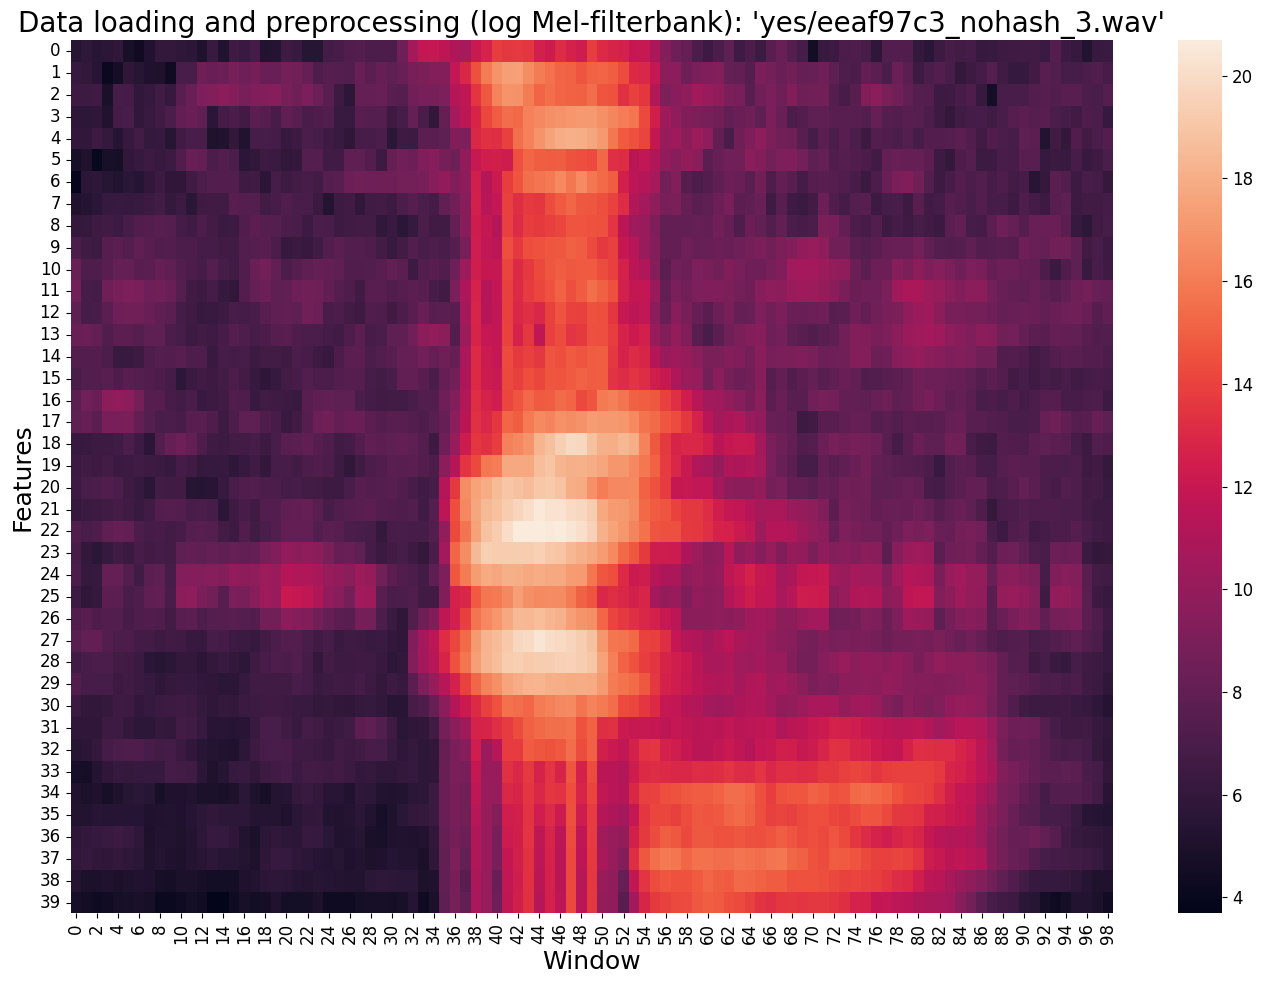

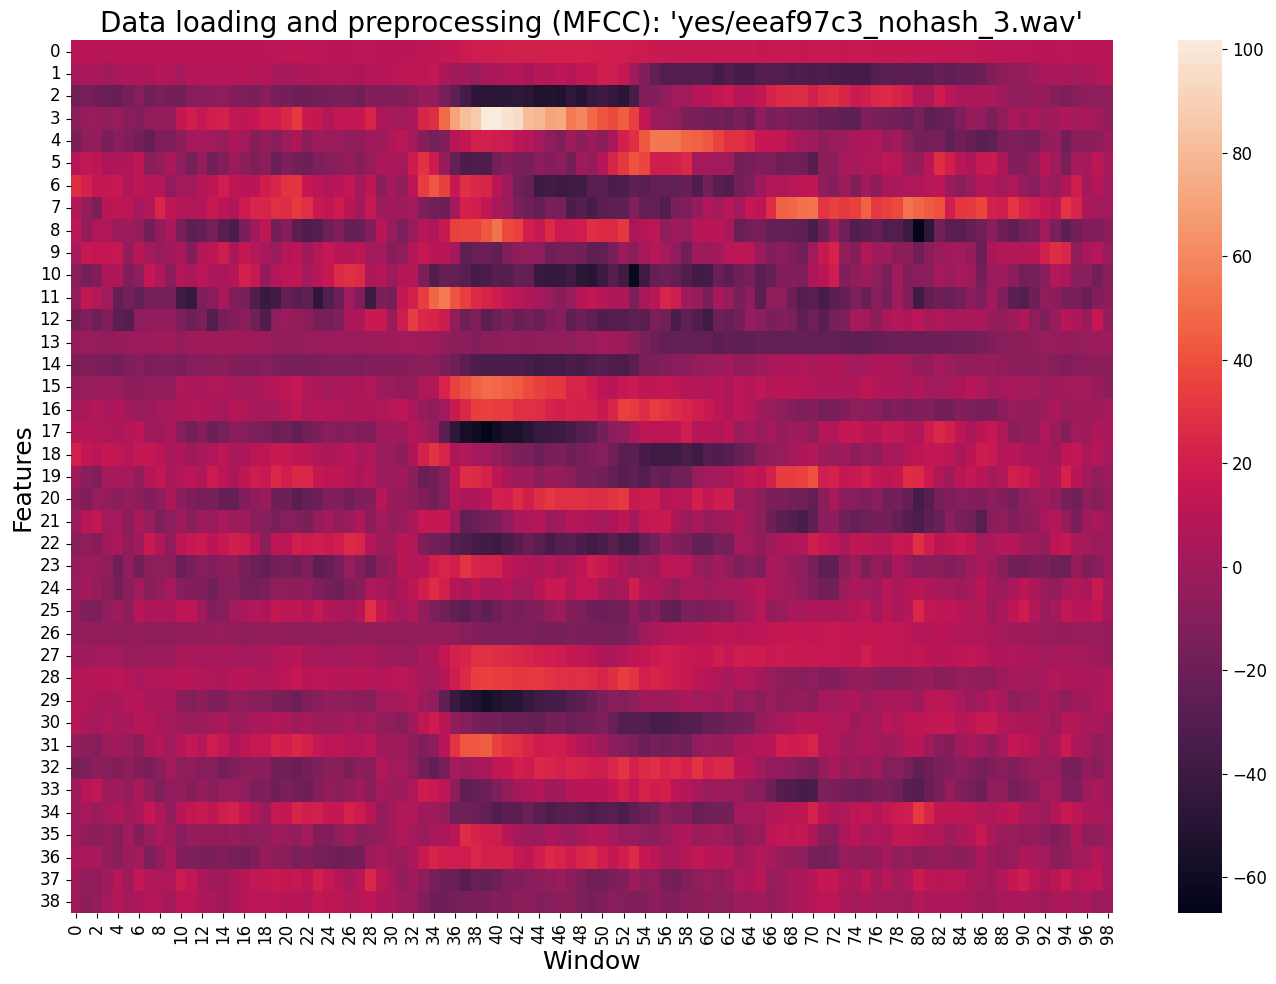

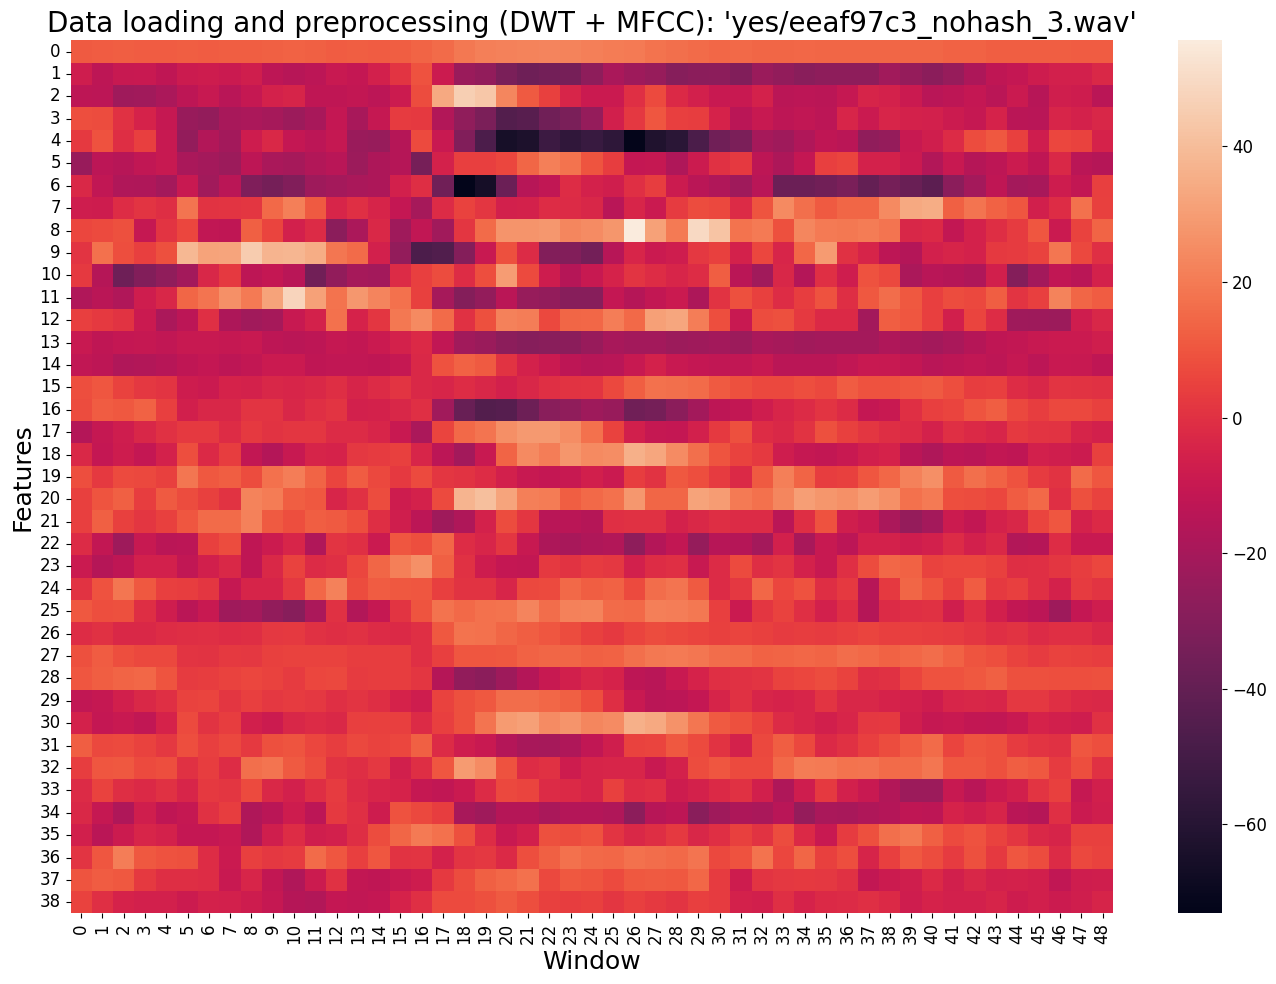

In [25]:
plot_obj = reference_df_train[reference_df_train.label=='yes'].iloc[10]

# Example using spectrogram
plot_data = load_and_preprocess_data(plot_obj.file, plot_obj.label, apply_background_noise=False, features=3)
plot_utils.plot_features(plot_data, title="Data loading and preprocessing (spectrogram): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

# Example using log Mel-filterbank energy features
plot_data = load_and_preprocess_data(plot_obj.file, plot_obj.label, apply_background_noise=False, features=2)
plot_utils.plot_features(plot_data, title="Data loading and preprocessing (log Mel-filterbank): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

# Example using MFCC features
plot_data = load_and_preprocess_data(plot_obj.file, plot_obj.label, apply_background_noise=False, features=1)
plot_utils.plot_features(plot_data, title="Data loading and preprocessing (MFCC): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

# Example using Discrete Wavelet Transform + MFCC features
plot_data = load_and_preprocess_data(plot_obj.file, plot_obj.label, apply_background_noise=False, features=4)
plot_utils.plot_features(plot_data, title="Data loading and preprocessing (DWT + MFCC): '%s/{}'".format(plot_obj.file) %(plot_obj.label))

### 2.1 - Dataset definition
We now define the `create_dataset` function, which initializes a `tf.data.Dataset` object and properly maps all the required processing. More details on this procedure can be found [here](https://www.tensorflow.org/guide/performance/datasets), along with additional tips and tricks for performance optimization.

In [26]:
def create_dataset(df, data_path_=data_path, apply_background_noise=False, features=1, cache_file=None, shuffle=True, batch_size=32):

    # Convert DataFrame to lists
    file_names = df['file'].tolist()
    file_labels = df['class'].tolist()

    # Create a Dataset object
    dataset = tf.data.Dataset.from_tensor_slices((file_names, file_labels))

    # Map the load_and_preprocess_data function
    def numpy_func(file_name, file_label):
        return tf.numpy_function(load_and_preprocess_data, inp=[file_name, file_label, data_path_, apply_background_noise, features], Tout=tf.float32), file_label
    dataset = dataset.map(numpy_func, num_parallel_calls=os.cpu_count())

    # Cache
    if cache_file:
        dataset = dataset.cache(filename=cache_file)

    # Shuffle
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))

    # Repeat the dataset indefinitely
    dataset = dataset.repeat()

    # Batch
    dataset = dataset.batch(batch_size=batch_size)

    # Prefetch
    dataset = dataset.prefetch(buffer_size=1)

    # Steps
    steps = int(np.ceil(len(df) / batch_size))

    return dataset, steps

### 2.2 - Dataset initialization
Finally, we define the training, validation and testing dataset, applying the above function to each of the corresponding reference dataframes. We also evaluate the number of steps (*train_steps*, *val_steps* and *test_steps*) required to load and process the entire dataset (num. of samples / batch_size).


In [27]:
apply_bn = True
features_to_extract = 4#1
batch_size = 32

train_dataset, train_steps = create_dataset(
    reference_df_train, 
    apply_background_noise=apply_bn,
    features=features_to_extract,
    cache_file='train_cache',
    shuffle=True,
    batch_size=batch_size
)

val_dataset, val_steps = create_dataset(
    reference_df_val,
    apply_background_noise=apply_bn,
    features=features_to_extract,
    cache_file='val_cache',
    shuffle=True,
    batch_size=batch_size
)

test_dataset, test_steps = create_dataset(
    reference_df_test,
    apply_background_noise=apply_bn, 
    features=features_to_extract,
    cache_file='test_cache',
    shuffle=True,
    batch_size=batch_size
)

## 3 - Models

### 3.1 - Import model
Here we select one of the available network architectures in the file `models_utils.py`.

In [28]:
############### Sainath15 notation ###############
t = 99 # input feature dimension in time
f = 39 # input feature dimension in frequency

# 1st CONV layer
m = 20 # filter size in time
r = 8  # filter size in frequency
s = 1  # stride in time
v = 1  # stride in frequency
p = 1  # max-pooling in time
q = 3  # max-pooling in frequency
##################################################

In [29]:
available_models()

Available models:
cnn_trad_fpool3
cnn_one_fpool3
cnn_one_fstride4
cnn_one_fstride8
smallCnnModel
cnnModel


In [30]:
features_to_input = { # input shapes
    1 : (99, 39),     # MFCC features
    2 : (99, 40),     # log Mel-filterbank energy features
    3 : (98, 257),    # spectrogram
    4 : (49, 39)      # Discrete Wavelet Transform + MFCC features
}

input_shape = features_to_input[features_to_extract]
model_name = 'smallCnnModel'
model = select_model(model_name, input_shape)

Selected model: smallCnnModel


In [31]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["sparse_categorical_accuracy"])
model.summary()

Model: "smallCnnModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 49, 39, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 49, 39, 32)        352       
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 39, 64)        10304     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 9, 64)        0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 49, 9, 64)        256       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 49, 9, 64)       

In [32]:
# Show the structure of the model through building blocks
# tf.keras.utils.plot_model(model, to_file=f'{model_name}.png')
# Image(f'{model_name}.png')

## 4 - Model training and testing

### 4.1 - Model training
At this point we can train the model for some epochs.

In [33]:
num_epochs = 20#10

early_stop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(f'trained_models/{model_name}.h5', monitor='val_loss', save_best_only=True)

history = model.fit(
                train_dataset,
                epochs=num_epochs,
                steps_per_epoch=train_steps,
                validation_data=val_dataset,
                validation_steps=val_steps,
                callbacks=[early_stop_callback, model_checkpoint], 
                verbose=1
                )

Epoch 1/20


2023-01-12 18:31:31.182223: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1594 of 25453
2023-01-12 18:31:41.254554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 2613 of 25453
2023-01-12 18:31:51.192689: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4350 of 25453
2023-01-12 18:32:01.197634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6227 of 25453
2023-01-12 18:32:11.180664: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8443 of 25453
2023-01-12 18:32:21.188965: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 10998 of 25453
2023-01-12 18:32:31.181132: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling

796/796 [==============================] - ETA: 0s - loss: 2.8332 - sparse_categorical_accuracy: 0.2240

2023-01-12 18:35:34.974842: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1991 of 2994
2023-01-12 18:35:40.132532: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-12 18:35:40.212156: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


796/796 [==============================] - 264s 178ms/step - loss: 2.8332 - sparse_categorical_accuracy: 0.2240 - val_loss: 1.8269 - val_sparse_categorical_accuracy: 0.4574
Epoch 2/20
796/796 [==============================] - 123s 155ms/step - loss: 1.8510 - sparse_categorical_accuracy: 0.4634 - val_loss: 1.3619 - val_sparse_categorical_accuracy: 0.6007
Epoch 3/20
796/796 [==============================] - 124s 156ms/step - loss: 1.5591 - sparse_categorical_accuracy: 0.5428 - val_loss: 1.2050 - val_sparse_categorical_accuracy: 0.6519
Epoch 4/20
796/796 [==============================] - 123s 155ms/step - loss: 1.3936 - sparse_categorical_accuracy: 0.5899 - val_loss: 1.1185 - val_sparse_categorical_accuracy: 0.6752
Epoch 5/20
796/796 [==============================] - 123s 154ms/step - loss: 1.3041 - sparse_categorical_accuracy: 0.6132 - val_loss: 1.0764 - val_sparse_categorical_accuracy: 0.6888
Epoch 6/20
796/796 [==============================] - 123s 155ms/step - loss: 1.2203 - spar

In [34]:
print('Training history:')
pd.DataFrame(history.history)

Training history:


,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,2.833206,0.224011,1.826898,0.457447
1,1.850958,0.463372,1.361934,0.600731
2,1.559055,0.542831,1.205013,0.651928
3,1.393624,0.589903,1.118491,0.675199
4,1.304080,0.613183,1.076402,0.688830
5,1.220253,0.635757,1.017970,0.701130
6,1.158644,0.651225,0.991201,0.713763
7,1.108278,0.670422,0.962175,0.718750
8,1.069433,0.676900,0.987406,0.715758
9,1.029693,0.686244,0.971574,0.715093


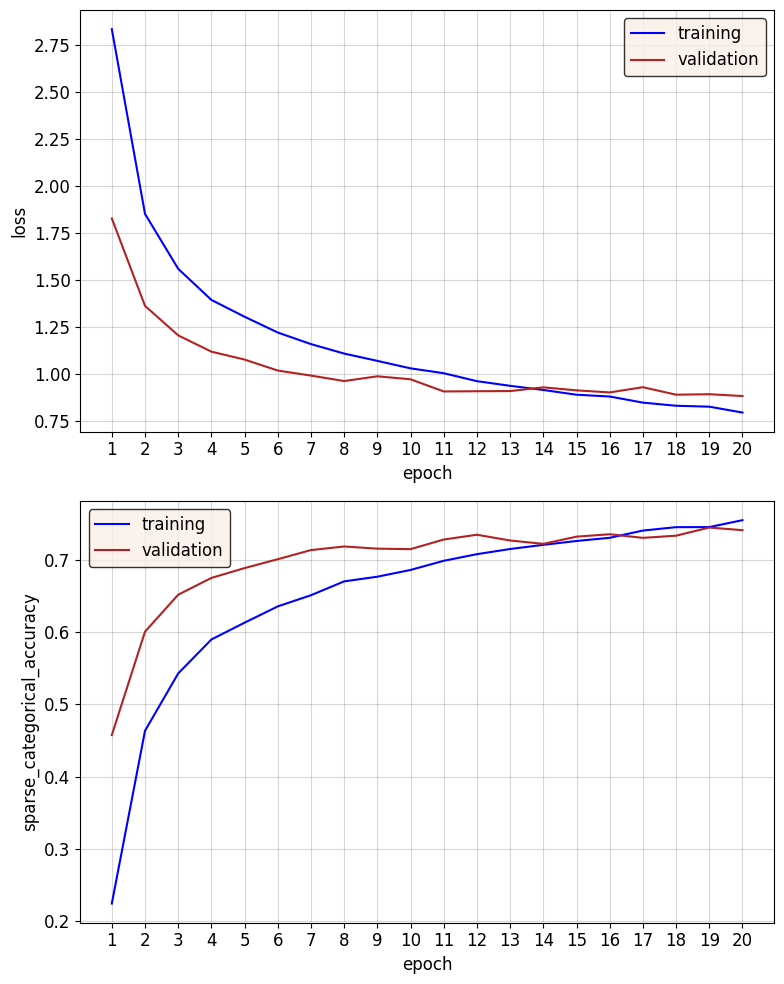

In [35]:
plot_utils.plot_history(history, columns=['loss', 'sparse_categorical_accuracy'])

Uncomment the cell below manually same the weights of the trained model.

In [ ]:
# model.save_weights(f'trained_models/{model_name}.h5')

Uncomment the cell below to load some pretrained models.

In [36]:
# model_name = 'smallCnnModel'
# model = tf.keras.models.load_model(f'{model_name}.h5')
# model.summary()

### 4.2 - Validation metrics
Since the dataset is unbalanced (see histograms in section 1.4) and we have more than 2 classes, the accuracy is not a good metric. To have a good understanding of the classifier performance we must rely on other metrics.  

First we compute the output of the network for all data in the test set. To obtain it use:
```python 
    model.predict(test_dataset, steps=test_steps)[:len(test_labels)].squeeze()
```
This is needed because the elements in `[len(val_labels):]` are not part of the dataset, but they are just added to complete the batch. 

Then we get the predicted label by computing the $argmax$ over the output of the network, for each input data. This is motivated by the fact that there are as many neurons as labels in the last layer of the network and we used the softmax activation function. 

In [37]:
# get predictions for test set
test_labels = reference_df_test['class']
test_pred = model.predict(test_dataset, steps=test_steps)[:len(test_labels)].squeeze()

# estimate class
y_pred = np.argmax(test_pred, axis=1)

# true labels
y_true = reference_df_test['class'].tolist()

2023-01-12 19:15:06.539128: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 1706 of 3302


  1/104 [..............................] - ETA: 30:04

2023-01-12 19:15:13.744429: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:417] Shuffle buffer filled.
2023-01-12 19:15:13.764248: W tensorflow/core/kernels/data/cache_dataset_ops.cc:296] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


104/104 [==============================] - 21s 38ms/step


Then, to visualize the performance of the algorithm we plot the confusion matrix:

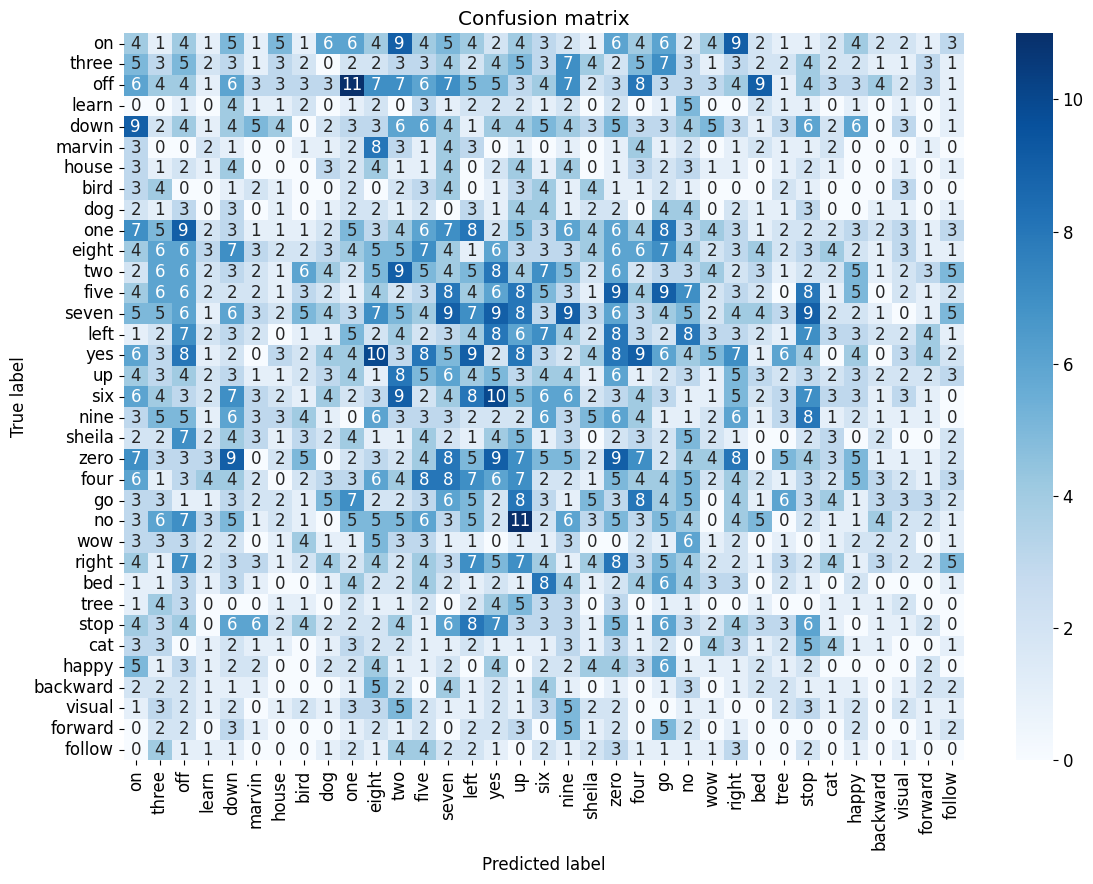

In [38]:
cm = confusion_matrix(y_pred, y_true)
plot_utils.plot_confusion_matrix(cm, labels=commands)
# plt.savefig(f'figures/cm_{model_name}.png')

Moreover, we can evaluate the _precision_, _recall_ and _fscore_ metrics using some methods from the *scikit-learn* library. These metrics are calculated for each class in the dataset, so to get an a high-level view of how our model is performing we need to aggregate them. This can be done in 3 main ways:

1. **Macro average**: it is the unweighted average of the selected metric; it does not take label unbalance into account.
2. **Micro average**: it is calculated by considering all the TP, TN, FP and FN for each class, adding them up and then using those to compute the metric’s micro-average; in other words it calculates the metrics globally by counting the total TP, FP and FN.
3. **Weighted average**: it is the average of the metric values for individual classes weighted by the support (i.e. the number of true instances) of that class. It alters _macro_ to account for label imbalance.

In our case, dealing with unbalanced classes, we are more interesting in the weighted average of the considered metrics.

Another interesting measure for multiclass classification is the _Cohen's Kappa score_. From [Wikipedia](https://en.wikipedia.org/wiki/Cohen%27s_kappa):
> Cohen’s kappa coefficient (κ) is a statistic that is used to measure inter-rater reliability (and also intra-rater reliability) for qualitative (categorical) items. It is generally thought to be a more robust measure than simple percent agreement calculation, as κ takes into account the possibility of the agreement occurring by chance.

It can be thought as a version of the accuracy which also integrates measurements of chance and class imbalance. Generally, a score above 0.8 is considered excellent. See [this guide](https://towardsdatascience.com/multi-class-metrics-made-simple-the-kappa-score-aka-cohens-kappa-coefficient-bdea137af09c) for more information about it. 



In [39]:
accuracy = accuracy_score(y_true=y_true, y_pred=y_pred)
logloss  = log_loss(y_true, test_pred, labels=np.arange(35))
cohen_k  = cohen_kappa_score(y_true, y_pred)

print('Accuracy:      {:.2f}%'.format(accuracy*100))
print('Error rate:    {:.2f}%'.format((1-accuracy)*100))
print('Cross-entropy: {:.2f}'.format(logloss))
print("Cohen's Kappa: {:.2f}".format(cohen_k))

def class_report(y_true, y_pred):
    precision_macro,    recall_macro,    fscore_macro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='macro')
    precision_micro,    recall_micro,    fscore_micro,    _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='micro')
    precision_weighted, recall_weighted, fscore_weighted, _ = precision_recall_fscore_support(y_true=y_true, y_pred=y_pred, average='weighted')
    
    df_report = pd.DataFrame(
        {
            'precision': [precision_macro, precision_micro, precision_weighted],
            'recall': [recall_macro, recall_micro, recall_weighted],
            'f1-score': [fscore_macro, fscore_micro, fscore_weighted]
        }, 
        index=['macro', 'micro', 'weighted']
    )
    
    return df_report

cr = class_report(y_true, y_pred)
display(cr.round(4))

Accuracy:      3.09%
Error rate:    96.91%
Cross-entropy: 11.70


,precision,recall,f1-score
macro,0.0257,0.0262,0.0259
micro,0.0309,0.0309,0.0309
weighted,0.0302,0.0309,0.0305


Uncomment the cell below to store the final metrics. 

In [ ]:
# weighted_metrics = cr.iloc[-1].tolist()

# df_metrics = pd.DataFrame(
#     weighted_metrics + [accuracy, logloss, cohen_k], 
#     columns = ['precision', 'recall', 'f1-score', 'accuracy', 'cross-entropy', 'Cohen-Kappa']
# )

# df_metrics.to_csv(f'metrics/metr_{model_name}.csv')
    

# References
**[Sainath15]** <br>
 Tara N. Sainath, Carolina Parada, _Convolutional Neural Networks for Small-footprint Keyword Spotting_, INTERSPEECH, Dresden, Germany, September 2015.

**[Warden18]** <br>
 Pete Warden, _Speech Commands: A Dataset for Limited-Vocabulary Speech Recognition_, arXiv:1804.03209, April 2018. 
 
**[Lyons14]** <br>
 James Lyons et al. (2020, January 14). jameslyons/python_speech_features: release v0.6.1 (Version 0.6.1). Zenodo.
